In [1]:
# !pip install debacl
# !pip install hdbscan

  Created wheel for debacl: filename=debacl-1.1-py3-none-any.whl size=24792 sha256=3a14e045f8e0b5b08595e319eba459a5a7676901cea662e7aabedcc0c2c7a00b
  Stored in directory: c:\users\04965\appdata\local\pip\cache\wheels\b1\1d\7b\e8464080d5108dfc26561c080bbafbd08e1026484ee6426a77
Successfully built debacl


## Import of libraries for clustering

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import time
import os
import struct
import re
import warnings

from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
import sklearn.cluster as cluster
from sklearn.cluster import DBSCAN

import debacl as dcl
import hdbscan
from hdbscan import HDBSCAN

C:\Users\04965\Anaconda3\envs\new_projects\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
"""
Load preapred dataset in terms of x, y, and z co-ordinates
"""

points = pd.read_pickle('processed_Cu-Cr-data_clustering_x_y_z.pkl')
points = points.iloc[:,:3].values

In [2]:
"""
The function that accepts 'min_cluster_radius_A' (in angstroms).
Returns the minimum no of atoms (data entires) to be classified as a cluster. This is an estimate.
The lattice parameter of precipitate rich in chromium is 3.68 A, reference below in the markdown section. 
"""

def min_atoms_per_cluster(min_cluster_radius_A = 2.0): 

    min_cluster_volume = (4*np.pi/3)*(min_cluster_radius_A**3)*0.5  # aspect ratio of 0.5 in the 3rd dimension
    
    # Unit cell related dimensions and volume
    unitcell_volume = 3.68**3      # in A^3
    
    # 4 atoms per FCC unit cell
    atoms_per_unitcell = 4  
    
    atoms_in_cluster = (min_cluster_volume/unitcell_volume)*atoms_per_unitcell
    
    #detection_eff: to compare with the measured dataset and the true atomic density in the material
    detection_eff = 0.80 
    
    # estimate of no of atoms detected experimentally in a cluster
    return int(np.floor((atoms_in_cluster)*detection_eff))  
    

- The lattice parameter of precipitates containing Cr is 3.68 A and can be found in my [publication](https://www.sciencedirect.com/science/article/abs/pii/S1359645420305413)
    - so that unit cell volume = 3.68^3 
- The [detection effeciency](https://www.cameca.com/products/apt/leap-5000) of the experimental instrument for atom probe tomography, i.e. LEAP 5000, is 80 % 
- The clusters are expected to be of FCC crystal structure due to low nucleation barrier, as the matrix is copper FCC. 
- The [paper](https://www.sciencedirect.com/science/article/abs/pii/S1359645499004115?via%3Dihub) by Fujii et al. argue in favor of this argument. Therefore, the number of atoms per FCC unit cell is 4.

In [3]:
# cluster diameter = 2.6 nm; radius = 1.3 nm
min_atoms_per_cluster(min_cluster_radius_A = 13) 

295

## HDBSCAN clusteing model training with different hyperparameters


**Why HDBSCAN algorithm?**

- (1) Due to the constraint from physics, specifically from experimental atom probe tomography (APT), that the clusters are associated with different atomic densities. The details may be found in this [paper](https://www.sciencedirect.com/science/article/pii/S0304399101001206?casa_token=iN0WBVLBsI0AAAAA:rzLszlgFV2A3CgGdbZ_GG84EPLN7DZISxJRQaRWpHIkEitoI20M6d3exd47WxfXXQvxsDyChyJU) 

- (2) The input experimental spatial data, is expected to be associated with Gaussian noise. HDBSCAN is robust for this purpose as well.
- (3) Possibility to also extract hierarchical relation between noted clusters. 
- (4) The present work draws from the [publication](https://www.sciencedirect.com/science/article/abs/pii/S0304399118303267) by Ghamarian and Marquis, but differs in on following counts:
    - model hyperparameters
    - additional criterion for outlier identification and removal. 
    - Implementation in python, as opposed to Matlab by Ghamarian et al.  

**Hyperparameters and their role:**
- (1) min_cluster_size         : single linkage splits that contain fewer points than this, will be considered points "falling out" of a cluster rather than a cluster splitting into two new clusters.       
- (2) cluster_selection_epsilon: ensures that clusters below the given threshold are not split up any further.
- (3) cluster_selection_method : 'left' provides the most fine-grained and homogeneous clusters.

In [28]:
# Now, let me use the estimate obtained based on cluster radius input into the HDBSCAN model
hdb0 = HDBSCAN(min_cluster_size= 295, cluster_selection_epsilon=0, cluster_selection_method='leaf', allow_single_cluster=True, gen_min_span_tree=True).fit(points)
hdb_labels0 = hdb0.labels_

n_clusters_hdb_0 = len(set(hdb_labels0)) - (1 if -1 in hdb_labels0 else 0)

print('\n\n++ HDBSCAN Results')
print('Estimated number of clusters:  %d' % (n_clusters_hdb_0))
# Duration 18-24 min if full RAM is being used or not



++ HDBSCAN Results
Estimated number of clusters:  319


In [4]:
# cluster diameter = 2 nm; radius = 1.0 nm
min_atoms_per_cluster(min_cluster_radius_A = 10)

134

In [87]:
hdb0 = HDBSCAN(min_cluster_size= 134, cluster_selection_epsilon=0, cluster_selection_method='leaf', allow_single_cluster=True, gen_min_span_tree=True).fit(points)
hdb_labels0 = hdb0.labels_

n_clusters_hdb_0 = len(set(hdb_labels0)) - (1 if -1 in hdb_labels0 else 0)

print('\n\n++ HDBSCAN Results')
print('Estimated number of clusters:  : %d' % (n_clusters_hdb_0))



++ HDBSCAN Results
Estimated number of clusters:  : 840


In [97]:
hdb0 = HDBSCAN(min_cluster_size= 50, cluster_selection_epsilon=0, cluster_selection_method='leaf', allow_single_cluster=True, gen_min_span_tree=True).fit(points)
hdb_labels0 = hdb0.labels_

n_clusters_hdb_0 = len(set(hdb_labels0)) - (1 if -1 in hdb_labels0 else 0)

print('\n\n++ HDBSCAN Results')
print('Estimated number of clusters:  : %d' % (n_clusters_hdb_0))



++ HDBSCAN Results
Estimated number of clusters:  : 3264


In [8]:
hdb0 = HDBSCAN(min_cluster_size= 30, cluster_selection_epsilon=0, cluster_selection_method='leaf', allow_single_cluster=True, gen_min_span_tree=True).fit(points)
hdb_labels0 = hdb0.labels_

n_clusters_hdb_0 = len(set(hdb_labels0)) - (1 if -1 in hdb_labels0 else 0)

print('\n\n++ HDBSCAN Results')
print('Estimated number of clusters:  : %d' % (n_clusters_hdb_0))



++ HDBSCAN Results
Estimated number of clusters:  : 5811


In [ ]:
hdb0 = HDBSCAN(min_cluster_size= 1075, cluster_selection_epsilon=0, cluster_selection_method='leaf', allow_single_cluster=True, gen_min_span_tree=True).fit(points)
hdb_labels0 = hdb0.labels_
# Number of clusters in labels, ignoring noise if present
# Reference: https://michael-fuchs-python.netlify.app/2020/06/20/hdbscan/
n_clusters_hdb_0 = len(set(hdb_labels0)) - (1 if -1 in hdb_labels0 else 0)

print('\n\n++ HDBSCAN Results')
print('Estimated number of clusters:  %d' % (n_clusters_hdb_0))
# Duration > 2.30 hrs for cluster size of 1075

## Retrieve and save results of HDBSCAN clustering model for each hyperparameter

In [9]:
"""
Construction of a dataframe using clustering results: labels, probabilities, outlier_scores. 
Each of the three columns are attributes of the fitted model.
Note: length of each of the three outputs are the same, and correspond to each data entry.
"""
result = pd.DataFrame({'labels': list(hdb0.labels_),'probabilities': list(hdb0.probabilities_) ,'outlier_scores': list(hdb0.outlier_scores_)}, columns=['labels', 'probabilities','outlier_scores'])

In [10]:
def dict_persistance_from_lables(model = hdb0):
    upper_bound_range = len(set(model.labels_)) - 1
    dict_label_persistance = dict(zip(list(range(upper_bound_range)), list(model.cluster_persistence_)))
    dict_label_persistance[-1] = np.nan
    return dict_label_persistance

In [11]:
dict_label_persistance = dict_persistance_from_lables(model = hdb0)

In [12]:
result.head()

,labels,probabilities,outlier_scores
0,-1,0.0,0.000845
1,-1,0.0,0.011399
2,-1,0.0,0.012574
3,-1,0.0,0.006462
4,5508,1.0,0.000000


## populate cluster_persistance scores for each dataentry by mapping with label ID number 

In [13]:
result['cluster_persistence'] = result['labels'].map(dict_label_persistance)

In [14]:
result.head()

,labels,probabilities,outlier_scores,cluster_persistence
0,-1,0.0,0.000845,NaN
1,-1,0.0,0.011399,NaN
2,-1,0.0,0.012574,NaN
3,-1,0.0,0.006462,NaN
4,5508,1.0,0.000000,0.690904


In [15]:
result.to_pickle('HDBSCAN_clustersize30_noofclusters5811.pkl')

## Frequency distribution curves: 'outlier_scores' and 'probabilities' associated with clusters

C:\Users\04965\Anaconda3\envs\new_projects\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
INFO (2021-10-30 11:21:31): NumExpr defaulting to 8 threads.
C:\Users\04965\Anaconda3\envs\new_projects\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

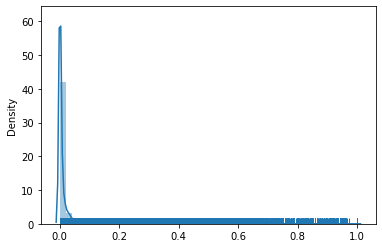

In [16]:
sns.distplot(hdb0.outlier_scores_[np.isfinite(hdb0.outlier_scores_)], rug=True)

C:\Users\04965\Anaconda3\envs\new_projects\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\04965\Anaconda3\envs\new_projects\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

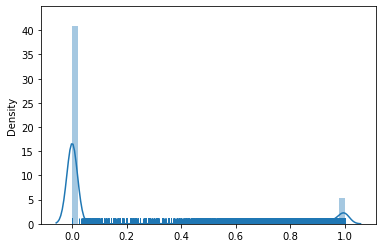

In [17]:
sns.distplot(hdb0.probabilities_[np.isfinite(hdb0.probabilities_)], rug=True)

In [18]:
sum(hdb0.cluster_persistence_)

498.2195061876099

C:\Users\04965\Anaconda3\envs\new_projects\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\04965\Anaconda3\envs\new_projects\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

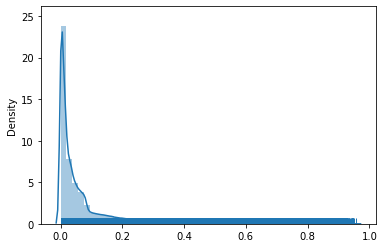

In [35]:
sns.distplot(hdb0.outlier_scores_[np.isfinite(hdb0.outlier_scores_)], rug=True)

In [36]:
hdb0.probabilities_

array([0., 0., 0., ..., 0., 0., 0.])

In [42]:
len(hdb0.probabilities_)

2298749

C:\Users\04965\Anaconda3\envs\new_projects\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\04965\Anaconda3\envs\new_projects\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

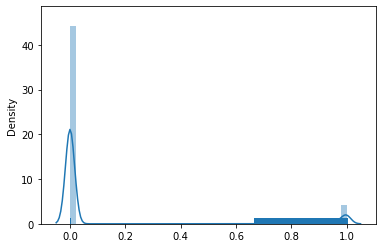

In [37]:
sns.distplot(hdb0.probabilities_[np.isfinite(hdb0.probabilities_)], rug=True)

In [38]:
len(set(hdb0.labels_)) # 319 clusters and 1 for noise

320